In [1]:
from qiskit import QuantumCircuit
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import *
# from qiskit.quantum_info import Statevector

In [2]:
qc = QuantumCircuit(2)
# qc.h(0)
# qc.measure(0, 0)


In [3]:

# Statevector(qc)
DensityMatrix(qc)

DensityMatrix([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
              dims=(2, 2))


Lets create a superposition state

In [4]:
qc = QuantumCircuit(1)
qc.h(0)
# qc.measure(0, 0)

Visulaize circuit 

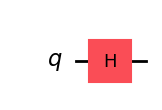

In [5]:
qc.draw('mpl')

In [6]:
Statevector(qc)
# DensityMatrix(qc)

Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))


Running circuit and getting counts 

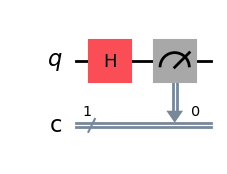

In [7]:
qc = QuantumCircuit(1,1)
qc.h(0)
qc.measure(0, 0)
qc.draw('mpl')

Using Run

In [8]:
from qiskit import QuantumRegister , ClassicalRegister , QuantumCircuit
from qiskit_aer import StatevectorSimulator, QasmSimulator, AerSimulator
from qiskit.visualization import plot_histogram

qreg_q = QuantumRegister(1,'q')
creg_c = ClassicalRegister(1,'c')

qc = QuantumCircuit(qreg_q,creg_c)

qc.h(qreg_q[0])
qc.measure(qreg_q,creg_c)

# M_simulator = QasmSimulator()

# M_simulator = StatevectorSimulator()
M_simulator = AerSimulator()

job = M_simulator.run(qc,shots=1024)
result = job.result()
result.get_counts(qc)

{'0': 525, '1': 499}

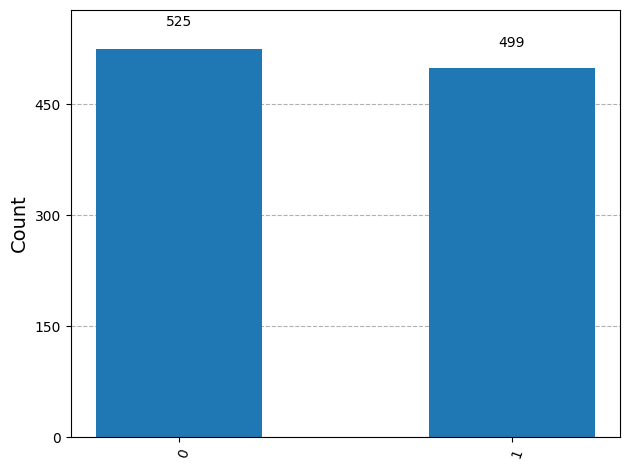

In [9]:
plot_histogram(result.get_counts(qc))

Running on Hardware and transpilation 

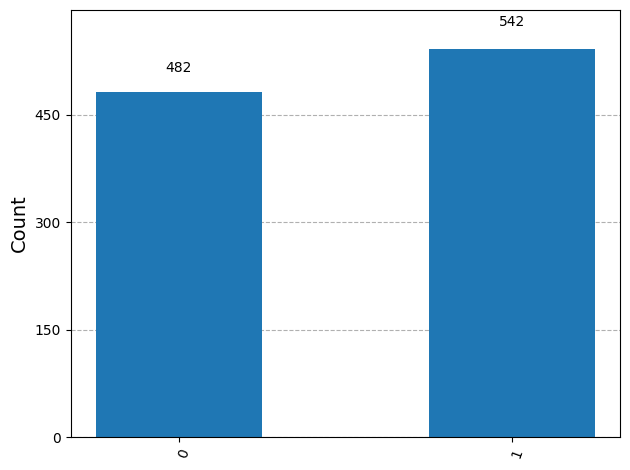

In [10]:
from qiskit import QuantumCircuit, transpile
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.visualization import plot_histogram
 
# Generate a 5-qubit simulated backend
backend = GenericBackendV2(num_qubits=5)
 
# Create a simple circuit
circuit = QuantumCircuit(1)
circuit.h(0)
circuit.measure_all()
circuit.draw('mpl')
 
# Transpile the ideal circuit to a circuit that can be directly executed by the backend
transpiled_circuit = transpile(circuit, backend)
transpiled_circuit.draw('mpl')
 
# Run the transpiled circuit using the simulated backend
job = backend.run(transpiled_circuit)
counts = job.result().get_counts()
plot_histogram(counts)

Using Sampler

In [11]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

from qiskit_aer import StatevectorSimulator, QasmSimulator
# from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import Pauli
from qiskit.visualization import plot_histogram


# simulator backend
# backend = StatevectorSimulator()
# backend = QasmSimulator()
backend = AerSimulator()


# Quantum circuit to make a  state
bell = QuantumCircuit(1,1)
bell.h(0)
# bell.cx(0, 1)
bell.measure_all()
 
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(bell)
 
# execute the quantum circuit
# sampler = AerSimulator()
sampler = Sampler(backend)
job = sampler.run([isa_circuit])
result = job.result()
 
print(result)

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=1>), meas=BitArray(<shape=(), num_shots=1024, num_bits=1>)), metadata={'shots': 1024, 'circuit_metadata': {}})], metadata={'version': 2})


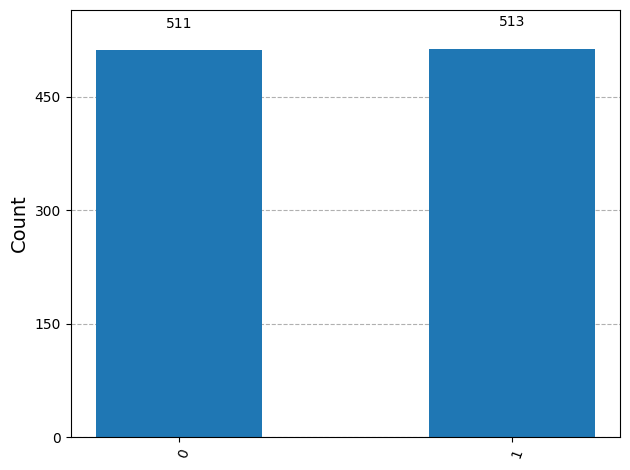

In [12]:
plot_histogram(result[0].data.meas.get_counts())

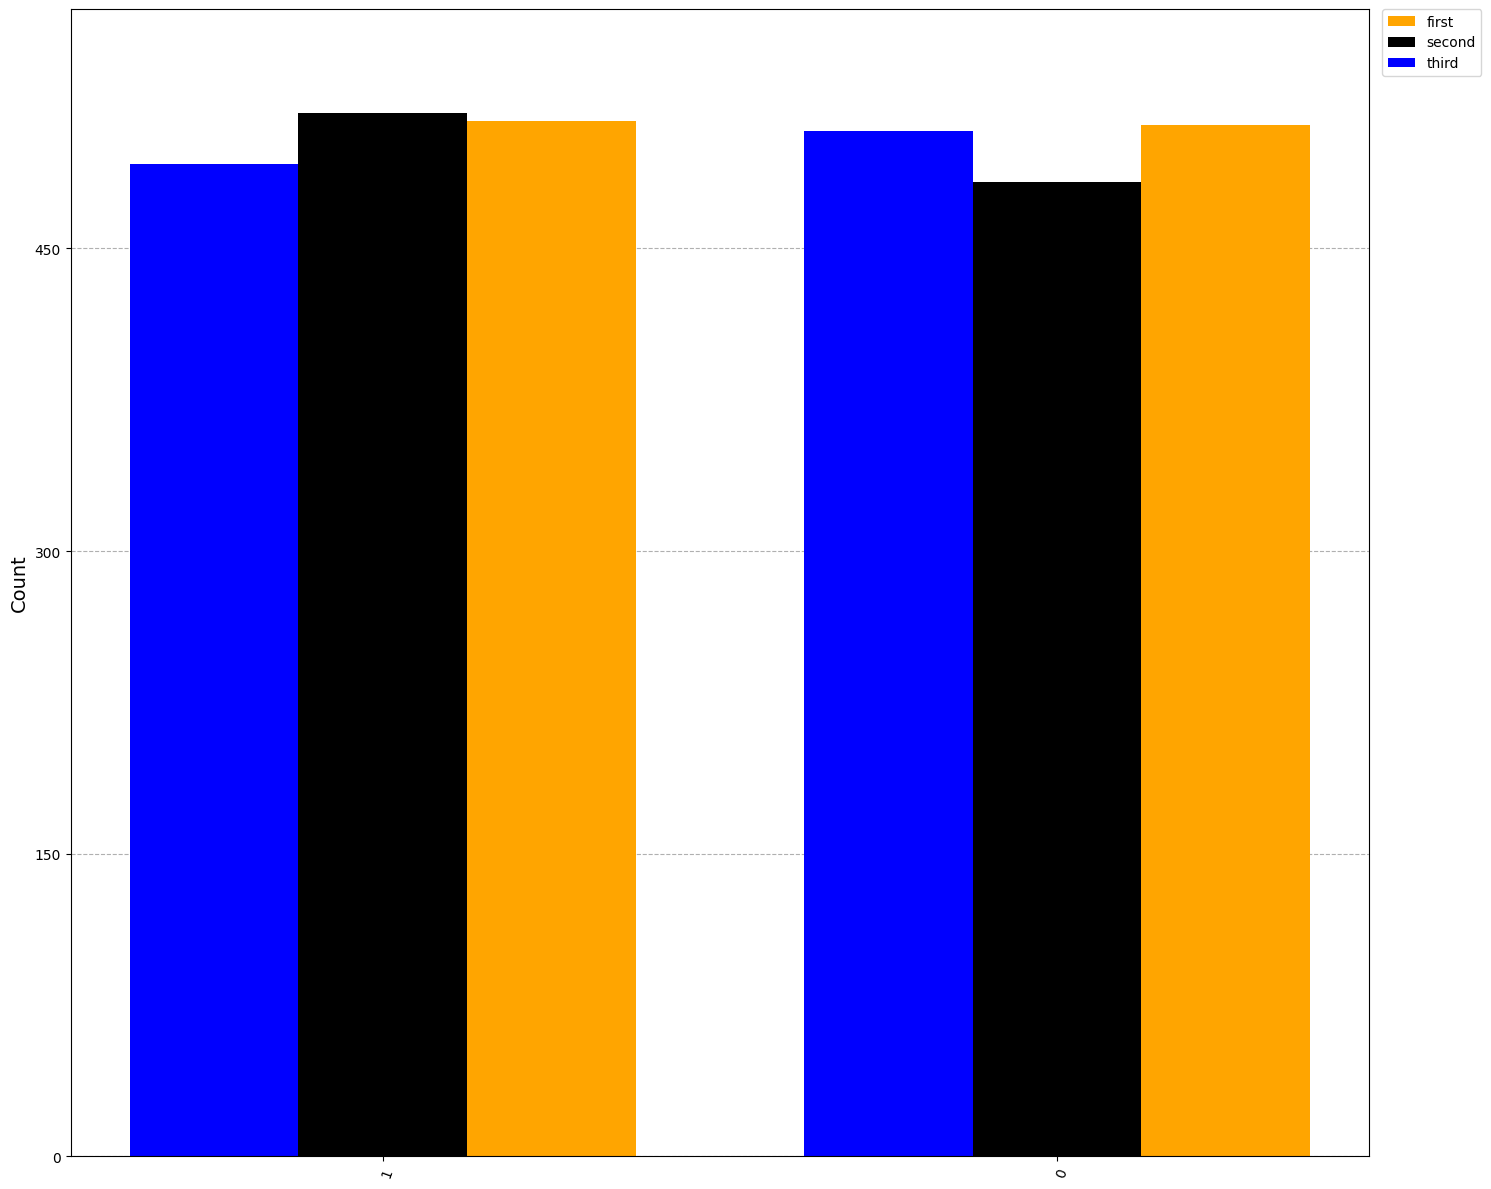

In [13]:
# Execute two-qubit Bell state again
sampler.options.default_shots = 1000
 
job = sampler.run([isa_circuit])
second_result = job.result()
job3 = sampler.run([isa_circuit])
third_result = job3.result()
 
# Plot results with custom options
plot_histogram(
    [
        result[0].data.meas.get_counts(),
        second_result[0].data.meas.get_counts(),
        third_result[0].data.meas.get_counts()
    ],
    legend=["first", "second", "third"],
    sort="desc",
    figsize=(15, 12),
    color=["orange", "black", "blue"],
    bar_labels=False,
)

Using Estimators

PubResult(data=DataBin(evs=np.ndarray(<shape=(7, 1), dtype=float64>), stds=np.ndarray(<shape=(7, 1), dtype=float64>), shape=(7, 1)), metadata={'target_precision': 0.015625, 'shots': 4096, 'circuit_metadata': {}})


<BarContainer object of 7 artists>

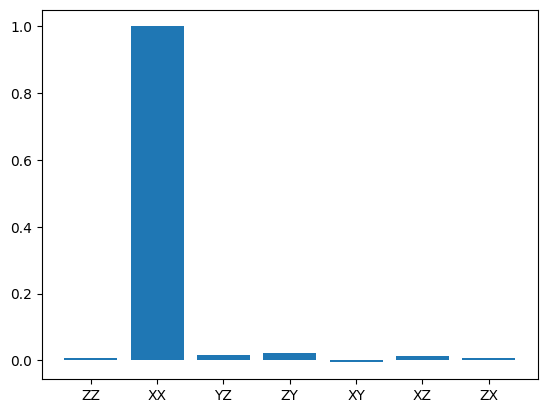

In [14]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.transpiler import generate_preset_pass_manager
from matplotlib import pyplot as plt
 
# Simple estimation experiment to create results
qc = QuantumCircuit(2)
qc.h(0)
qc.h(1)
# qc.crx(1.5, 0, 1)
 
observables_labels = ["ZZ", "XX", "YZ", "ZY", "XY", "XZ", "ZX"]
observables = [SparsePauliOp(label) for label in observables_labels]
 
# service = QiskitRuntimeService()
backend = AerSimulator()
 
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(qc)
isa_observables = [
    operator.apply_layout(isa_circuit.layout) for operator in observables
]
 
# Reshape observable array for broadcasting
reshaped_ops = np.fromiter(isa_observables, dtype=object)
reshaped_ops = reshaped_ops.reshape((7, 1))
 
estimator = Estimator(backend)
job = estimator.run([(isa_circuit, reshaped_ops)])
result = job.result()[0]
exp_val = job.result()[0].data.evs
print(result)
 
# Since the result array is structured as a 2D array where each element is a
# list containing a single value, you need to flatten the array.
 
# Plot using Matplotlib
plt.bar(observables_labels, exp_val.flatten())

Text(0.5, 1.0, 'Expectation values (with standard errors)')

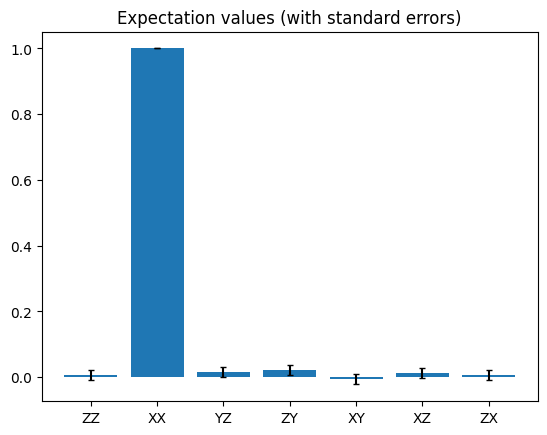

In [15]:
standard_error = job.result()[0].data.stds
 
_, ax = plt.subplots()
ax.bar(
    observables_labels,
    exp_val.flatten(),
    yerr=standard_error.flatten(),
    capsize=2,
)
ax.set_title("Expectation values (with standard errors)")

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=3>), meas=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'shots': 1024, 'circuit_metadata': {}})], metadata={'version': 2})


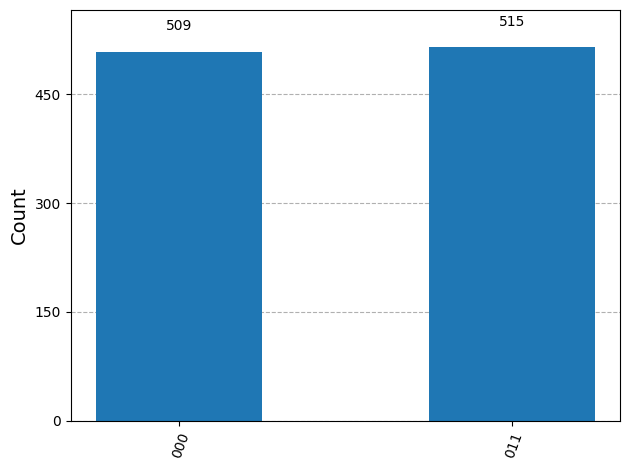

In [16]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

from qiskit_aer import StatevectorSimulator, QasmSimulator
# from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import Pauli
from qiskit.visualization import plot_histogram


# simulator backend
# backend = StatevectorSimulator()
# backend = QasmSimulator()
backend = AerSimulator()


# Quantum circuit to make a  state
qc1 = QuantumCircuit(3,3)
qc1.h(1)
qc1.cx(1,0)
#your code



#your code

qc1.measure_all()
qc1.draw('mpl')
 
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(qc1)

# execute the quantum circuit
# sampler = AerSimulator()
sampler = Sampler(backend)
job = sampler.run([isa_circuit])
result = job.result()
 
print(result)
plot_histogram(result[0].data.meas.get_counts())

# Q1: create a circuit whose resulting state is product state of bell state and single qubit state (Use atleast one toffoli gate). The obtained output counts will be your results, i.e. 000 = 1024. Is there any difference between theoretical and experimentally estimated results ? 

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=3>), meas=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'shots': 1024, 'circuit_metadata': {}})], metadata={'version': 2})


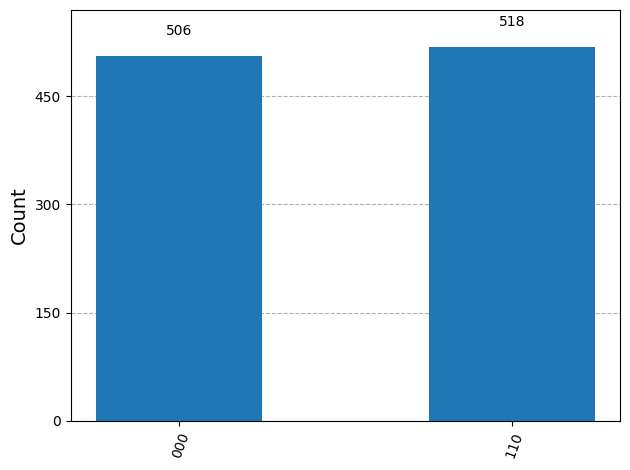

In [17]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_aer import StatevectorSimulator, QasmSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import Pauli
from qiskit.visualization import plot_histogram


# simulator backend
# backend = StatevectorSimulator()
# backend = QasmSimulator()
backend = AerSimulator()


# Quantum circuit to make a  state
qc1 = QuantumCircuit(3,3)
qc1.h(1)
qc1.cx(1,0)
#your code
qc1.ccx(0,1,2)
qc1.cx(1,0)



#your code

qc1.measure_all()
qc1.draw('mpl')
 
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(qc1)

# execute the quantum circuit
# sampler = AerSimulator()
sampler = Sampler(backend)
job = sampler.run([isa_circuit])
result = job.result()
 
print(result)
plot_histogram(result[0].data.meas.get_counts())

# construct a swap gate and confirm your swap action


# confirm your swap action 

In [22]:
# Quantum circuit to make a  state
qc1 = QuantumCircuit(2,2)

# varying initial states
qc1.x(0)
# qc1.x(1)

#---your code

qc1.cx(1,0)
qc1.cx(0,1)
qc1.cx(1,0)



#-- --------

Statevector(qc1)

Statevector([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
            dims=(2, 2))


In [21]:
qc1 = QuantumCircuit(2,2)

# varying initial states
qc1.x(0)
# qc1.x(1)
Statevector(qc1)

Statevector([0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2))


# Q 2

PubResult(data=DataBin(evs=np.ndarray(<shape=(2, 1), dtype=float64>), stds=np.ndarray(<shape=(2, 1), dtype=float64>), shape=(2, 1)), metadata={'target_precision': 0.015625, 'shots': 4096, 'circuit_metadata': {}})


<BarContainer object of 2 artists>

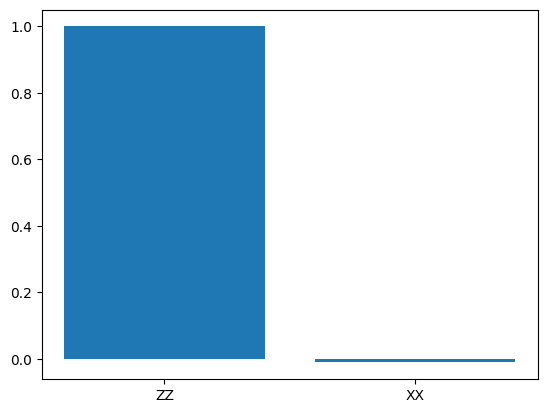

In [23]:

import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Pauli
from qiskit.visualization import plot_histogram
from matplotlib import pyplot as plt


# simulator backend
# backend = StatevectorSimulator()
# backend = QasmSimulator()
backend = AerSimulator()


# Quantum circuit to make a  state
qc1 = QuantumCircuit(2,2)

#your code
qc1.cx(1,0)
qc1.cx(0,1)
qc1.cx(1,0)


#your code

# qc1.measure_all()
qc1.draw('mpl')
 
# pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
# isa_circuit = pm.run(qc1)

# # execute the quantum circuit
# # sampler = AerSimulator()
# sampler = Sampler(backend)
# job = sampler.run([isa_circuit])
# result = job.result()
 
# print(result)
# plot_histogram(result[0].data.meas.get_counts())


observables_labels = ["ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]
 
# service = QiskitRuntimeService()
backend = AerSimulator()
 
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(qc1)
isa_observables = [
    operator.apply_layout(isa_circuit.layout) for operator in observables
]
 
# Reshape observable array for broadcasting
reshaped_ops = np.fromiter(isa_observables, dtype=object)
reshaped_ops = reshaped_ops.reshape((2, 1))
 
estimator = Estimator(backend)
job = estimator.run([(isa_circuit, reshaped_ops)])
result = job.result()[0]
exp_val = job.result()[0].data.evs
print(result)
 
# Since the result array is structured as a 2D array where each element is a
# list containing a single value, you need to flatten the array.
 
# Plot using Matplotlib
plt.bar(observables_labels, exp_val.flatten())

In [ ]:
# from qiskit import QuantumRegister , ClassicalRegister , QuantumCircuit
# from qiskit_aer import StatevectorSimulator, QasmSimulator, AerSimulator
# from qiskit.visualization import plot_histogram



# qc1 = QuantumCircuit(3,3)
# qc1.h(1)
# qc1.cx(1,0)
# #your code



# #your code


# qc1.measure([0,1,2],[0,1,2])
# qc1.draw('mpl')

# M_simulator = AerSimulator()

# job = M_simulator.run(qc1,shots=1024)
# result = job.result()
# result.get_counts(qc1)
# plot_histogram(result.get_counts(qc1))

# Answers questions based on your results in google form

https://forms.gle/L4q2pmtHSbHpa3i16



To ponder over: can you create a gate which gives you action of 4 qubit gate whose 3 qubits are control and 1 qubit is target ? Try to construct such a gate using toffoli gate also utilise ancilla qubits if necessary